In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import random

In [2]:
from IPython.display import display, set_matplotlib_formats, Markdown

In [3]:
# Set the matplotlib graphs to be exported as svg
set_matplotlib_formats('svg')

## Learning to respond over time (autocorrelation)
Here we calculate and check the autocorrelation function for the customers who have responded in more than 5 DR events. We check the autocorrelation for various lags to check for randomness in the data. Autocorrelation is not the only metric used for randomness checking. You can check more [here](https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm). 

Check the autocorrelation for the time series of peak response data.

In [4]:
# import response-effort dataset
base_df = pd.read_csv('data/DPR_response_filtered.csv')

In [5]:
base_df.head()

,CUSTOMER_KEY,EVENT_KEY,ACTUAL_KWH,BASELINE_KWH,REBATE_AMOUNT,PEAK_EVENT_TYPE,pct_ch (%),response,non_response
0,10233684,1000250,1.344000,5.940998,20.7,DPR,-77.377538,True,False
1,10233698,1000248,1.859999,5.328998,15.6,DPR,-65.096647,True,False
2,10233698,1000266,2.096000,7.899000,26.1,DPR,-73.464996,True,False
3,10233730,1000246,1.170000,1.977999,3.6,DPR,-40.849313,True,False
4,10233730,1000242,1.288000,2.081499,3.6,DPR,-38.121517,True,False


In [6]:
# Create pivot table with selected columns
column_list = ['CUSTOMER_KEY', 'EVENT_KEY', 'pct_ch (%)']
sub_base_df = base_df[column_list]

pivot_df_filter = sub_base_df.pivot(index='CUSTOMER_KEY', columns='EVENT_KEY', values='pct_ch (%)')
pivot_df_filter.head()

EVENT_KEY,1000240,1000241,1000242,1000244,1000245,1000246,1000248,1000250,1000251,1000266
CUSTOMER_KEY,,,,,,,,,,
8145435,NaN,NaN,-76.919900,-24.504513,-71.305792,-68.102357,-33.465097,-1.730952,-75.545314,-91.967006
8145987,NaN,NaN,-63.876066,-14.405621,-69.078657,-72.014305,3.741643,-46.395758,NaN,-11.088040
8146093,NaN,NaN,-26.530924,-20.022305,-39.913615,NaN,-31.215153,-9.317357,-63.241655,-70.225873
8146235,NaN,NaN,-60.339398,-24.249793,-68.723410,-75.993899,-75.207209,-68.535670,-53.366716,-75.547653
8147619,NaN,NaN,NaN,-83.574970,-85.576823,-59.511283,-19.058378,-85.658174,-74.952315,10.037912


In [7]:
# Keep only the households that have responded to more than 5 events
response_pivot = pivot_df_filter[ pivot_df_filter.notna().sum(axis=1) > 5 ]

In [8]:
# Number of households after the filtering
response_pivot.shape

(767, 10)

We then go and calculate the autocorrelation function for each household. We create a long-format table that gives the ACF and necessary statistics for hypothesis testing. In order to to reject the null hypothesis of the Ljung-Box Q test (that the data are independently distributed) the p-values must have lower value than the aplha significance level. In this case we have selected the 5%.

We should note at this point that we drop from the analysis the events where the households have not participated. Here we try to check if consumers learn to respond better with each subsequent responding event (for each household).

In [9]:
# Parameters
alpha = 0.05

In [10]:
ACF_df_cols = [ 'lag_' + str(i) for i in range(response_pivot.shape[1]) ]
ACF_df = pd.DataFrame(index=response_pivot.index, columns=['ACF', 'Q_stats', 'p_vals'])

# populate the df
for customer, cust_data in response_pivot.iterrows():
    nlags = response_pivot.loc[customer, :].notna().sum() -1
    acf, conf, q_stat, p_val = sm.tsa.stattools.acf(cust_data.dropna().values, nlags=nlags, qstat=True, alpha=alpha, missing='drop', fft=False)
    ACF_df.loc[customer, 'ACF'] = acf
    ACF_df.loc[customer, 'Q_stats'] = q_stat
    ACF_df.loc[customer, 'p_vals'] = p_val
    
# Create a column to see if there are any statistically significant autocorrelation
ACF_df['ACF_bool'] = ACF_df['p_vals'].apply(lambda x: (x < alpha).any())

# Create columns indicating which autocorrelation lags are significant for each household
lags_list = ACF_df['p_vals'].apply(lambda x: np.nonzero(x < alpha)).apply(lambda x: (x[0] + 1).tolist()).values.tolist()
unique_lags = set().union(*lags_list)

# Create the lag bool columns indicating whether the Q-test was significant per household
for lag in unique_lags:
    col_name = 'signif_lag_' + str(lag)
    ACF_df[col_name] = [lag in x for x in lags_list]
    
ACF_df.head()

,ACF,Q_stats,p_vals,ACF_bool,signif_lag_1,signif_lag_2,signif_lag_3,signif_lag_4,signif_lag_5,signif_lag_6,signif_lag_7,signif_lag_8
CUSTOMER_KEY,,,,,,,,,,,,
8145435,"[1.0, -0.05733628023232179, -0.502154713946726...","[0.03757084606719239, 3.399695602586101, 3.466...","[0.8463074260635888, 0.18271133036486514, 0.32...",False,False,False,False,False,False,False,False,False
8145987,"[1.0, -0.3899012635663168, 0.01488176256394203...","[1.5962414509714096, 1.59903193336973, 2.22590...","[0.2064366662435144, 0.4495465069500515, 0.526...",False,False,False,False,False,False,False,False,False
8146093,"[1.0, 0.14055499494564433, -0.3595966253549723...","[0.2074349193437861, 1.8367375547240086, 2.139...","[0.6487853597874622, 0.39916964486154305, 0.54...",False,False,False,False,False,False,False,False,False
8146235,"[1.0, 0.0021395526588769893, -0.19439349054714...","[5.231640662980107e-05, 0.503903371967979, 1.1...","[0.9942289448039335, 0.7772822907908195, 0.756...",False,False,False,False,False,False,False,False,False
8147619,"[1.0, -0.12042687849039906, -0.412321486901503...","[0.15227764716088404, 2.2943911550252793, 3.51...","[0.6963681905420949, 0.3175259989603421, 0.318...",False,False,False,False,False,False,False,False,False


We then go and **plot** the distribution of the **1-lag** and **2-lag** autocorrelations across the participating households.

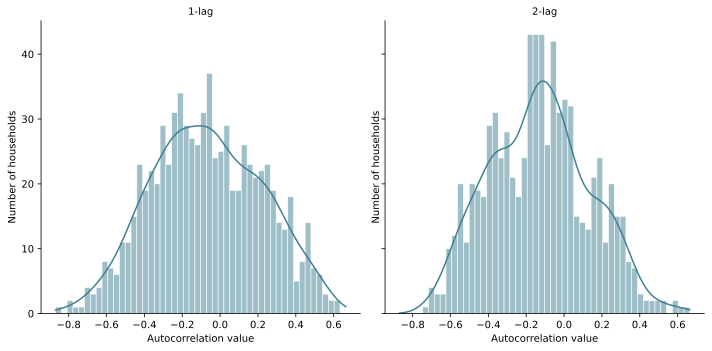

In [11]:
ACF_df['1-lag'] = ACF_df['ACF'].apply(lambda x: x[1]).values
ACF_df['2-lag'] = ACF_df['ACF'].apply(lambda x: x[2]).values

cols = ['1-lag', '2-lag']

g = sns.displot(ACF_df[cols].melt(var_name='acf_lag', value_name='Autocorrelation value'),
                x="Autocorrelation value", bins=50, kde=True, col='acf_lag',
                color=sns.diverging_palette(20, 220)[5],
                edgecolor="w")
g.set_titles(col_template="{col_name}")

g.set(ylabel="Number of households")

plt.tight_layout()
plt.show()

Even thought there is a number of participants that have relatively high autocorrelation for these lags, this can be deceiving. We need to test if the autocorrelations are also statistically significant.

In [12]:
display(Markdown('Out of a total of **{}** households, the number of households with significant results for autocorrelation are:'.format(response_pivot.shape[0])))
signif_acf_cols = ACF_df.columns[ACF_df.columns.str.contains('signif_lag_')]
num_cust_signif_acf = ACF_df[signif_acf_cols].sum()

for column_name, num in zip(signif_acf_cols, num_cust_signif_acf):
    display(Markdown('* `{}`: {}'.format(column_name, num)))

Out of a total of **767** households, the number of households with significant results for autocorrelation are:

* `signif_lag_1`: 20

* `signif_lag_2`: 16

* `signif_lag_3`: 27

* `signif_lag_4`: 19

* `signif_lag_5`: 24

* `signif_lag_6`: 17

* `signif_lag_7`: 13

* `signif_lag_8`: 1

#### ACF plots for various households
We then go and plot the autocorrelation function (ACF) for various random participating households in the DPR scheme.

In [13]:
# Helper function for plot
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

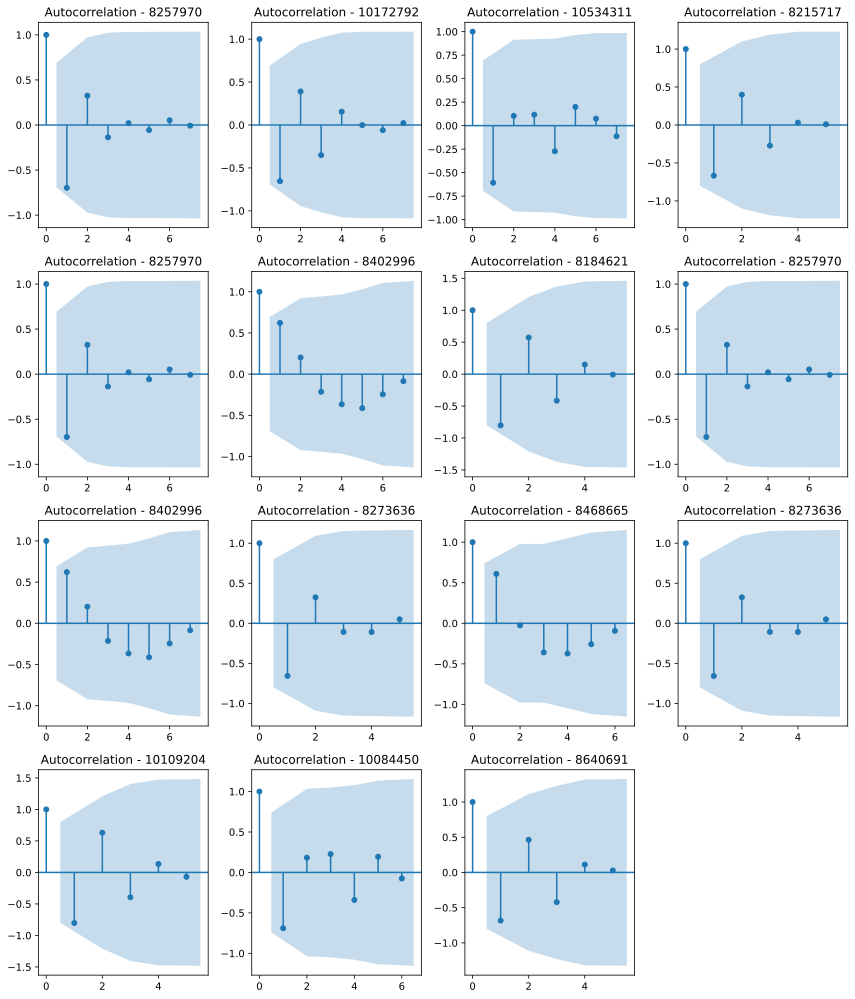

In [14]:
# Create list of random households
num_random = 15
population = ACF_df[ACF_df.signif_lag_1].index.values                   # ACF_df.index.values
customer_list = random.choices(population=population, k=num_random)

has_decimal = int(str(15/4-int(15/4))[2:]) != 0
term = has_decimal * 1
nrows = int(num_random/4) + term

# Have 4 cols and respective rows
fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 14))
axs = trim_axs(axs, len(customer_list))

# Get the number of lags for each household
for ax, df_data in zip(axs, response_pivot.loc[customer_list, :].iterrows()):
    customer = df_data[0]
    cust_data = df_data[1]
    
    sm.graphics.tsa.plot_acf(response_pivot.loc[customer].dropna().values,          # It is no problem that we drop the cases
                            title='Autocorrelation - ' + str(customer), 
                            ax=ax)
    
plt.tight_layout()
    
plt.show()

The **shaded region** in the plots is the confidence interval. The lags that lie above the blue line are the significant lags. In general we cannot see any point like that for the consumers we have sampled. Even the the customers with high 1-lag autocorrelation the don't show anything.